# Test 12

_Same as test11 but with different parameters_

The goal of this file is to compute the GS for several angles using MD.

**Simulation with LAMMPS**

Simulations are done by a Ramp (8mT/60s) + Evolution (60s) scheme


**Chirality**

Compute the chirality of the final states for all angles.

$$
    \Phi = \sum_{i,j} (-1)^{i+j}\chi_{ij}
$$

**Charge ordering**

Compute a complementary order parameter with topological charqes

$$
    \kappa = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

**Averaging**
From all the datasets, compute $\langle |\Phi|\rangle$ and $\langle |\kappa|\rangle$, as well as $\sigma_\Phi$ and $\sigma_\kappa$.

In [53]:
import os
import sys

import numpy as np
import pandas as pd
import random
from math import isclose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import *
from montecarlo_tools import *
from chirality_tools import *

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [3]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = True


## MD Simulations

This part only generates the datasets to work with for all angles.

In [4]:
params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":100e-6*ureg.pN/ureg.nm,
    
    "lattice_constant":15*ureg.um,
    "size" : 10
}

In [5]:
def get_md_colloid(angle):
    sp = ice.spins()

    # Particle parameters
    particle_radius = 1.4*ureg.um
    particle_susceptibility = 0.4
    particle_diffusion = 0.14*ureg.um**2/ureg.s
    particle_temperature = 300*ureg.K
    particle_density = 1000*ureg.kg/ureg.m**3

    # Trap parameters
    trap_separation = 3*ureg.um
    trap_height = 8*ureg.pN*ureg.nm
    trap_stiffness = 100e-6*ureg.pN/ureg.nm

    # Lattice parameters
    a = 15*ureg.um
    N = 10

    # Simulation parameters
    total_time = 120*ureg.s
    framespersec = 20*ureg.Hz;
    dt = 2*ureg.ms
    max_field = 5*ureg.mT
    sim_temp = 300*ureg.K
    sim_dipole_cutoff = 40*ureg.um

    # Colloid parameters
    col_height_spread = 0
    col_susceptibility_spread = 0.1
    col_isperiodic = True


    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=a, border="periodic")

    particle = ice.particle(radius = particle_radius,
                susceptibility = particle_susceptibility,
                diffusion = particle_diffusion,
                temperature = particle_temperature,
                density = particle_density)

    trap = ice.trap(trap_sep = trap_separation,
                height = trap_height,
                stiffness = trap_stiffness)

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = col_height_spread, 
                            susceptibility_spread = col_susceptibility_spread,
                            periodic = col_isperiodic)

        
    col.randomize()
    col.region = np.array([[0,0,-3*(particle_radius/a/N).magnitude],[1,1,3*(particle_radius/a/N).magnitude]])*N*a


    world = ice.world(
            field = max_field,
            temperature = sim_temp,
            dipole_cutoff = sim_dipole_cutoff,
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = "test",
                include_timestamp = False,
                targetdir = r".",
                framerate = framespersec,
                timestep = dt,
                run_time = total_time,
                output = ["x","y","z","mux","muy","muz"])

    # Field

    angle = np.round(angle*np.pi/180,decimals=6)
    col.sim.field.fieldx = f"v_Bmag*sin({angle})*time/60e6*(time<60e6)+v_Bmag*sin({angle})*(time>=60e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = f"v_Bmag*cos({angle})*time/60e6*(time<60e6)+v_Bmag*cos({angle})*(time>=60e6)"

    

    col.run_simulation();

    col.load_simulation()

    return col

This block checks which angles are going to be ran. Helps for running by batches.

In [ ]:
angle_completed = os.listdir("../data/test12/angles/")
angles = [angle for angle in range(0,90+1,1) if str(angle) not in angle_completed]
angle_select = angles[:]
angle_select

In [ ]:
runs = 10
data_path = "../data/test12/angles/"
for angle in tqdm(angle_select):
    print(f"===== Angle {angle} =====")

    main_angle_path = data_path + str(angle)
    trj_path = main_angle_path + "/trj/"
    ctrj_path = main_angle_path + "/ctrj/"

    try:
        os.mkdir(main_angle_path)
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass

    for i in range(1,runs+1):
        print(f"- Realization {i} -")
        
        col = get_md_colloid(angle)

        filename = f"trj{i}.csv"
        col.trj.to_csv(trj_path + filename)
        print("Saved trj")

        filename = f"ctrj{i}.csv"
        trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
        trj.to_csv(ctrj_path + filename)
        print("Saved ctrj")
        
    clear_output(wait=True)

This section graphs the fields just to check that everything is OK.

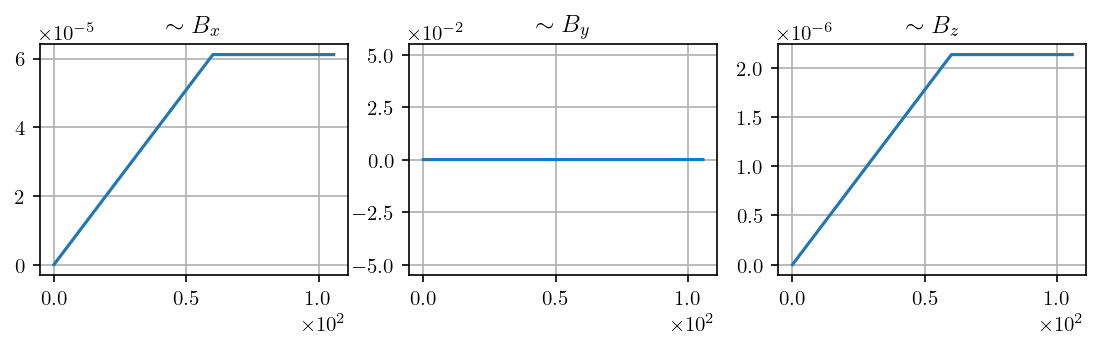

In [25]:
trj_raw = trj = pd.read_csv("../data/test12/angles/88/trj/trj3.csv", index_col=[0,1])
ctrj_raw = pd.read_csv("../data/test12/angles/88/ctrj/ctrj3.csv", index_col=[0,1])

fig, axes = plt.subplots(1,3,figsize=(9,2),dpi=150)

ax = axes[0]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"mux"]))
ax.set_title("$\\sim B_x$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[1]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muy"]))
ax.set_title("$\\sim B_y$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

ax = axes[2]
ax.plot(np.array(trj_raw.loc[idx[:,1],"t"]),np.array(trj_raw.loc[idx[:,1],"muz"]))
ax.set_title("$\\sim B_z$")
ax.ticklabel_format(style='sci',scilimits=(0,0))

plt.show()

# Chirality

This section deals with chirality computations for all angles. \
Check the _chirality_tools.py_ for more information.

In [7]:
# General information

particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"])

trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"])


params["particle"] = particle
params["trap"] = trap


In [10]:
angles_completed = np.sort([int(a) for a in os.listdir("../data/test12/angles")])
angles_completed

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [27]:
ctrj_raw

type      x      y    z            dx   dy   dz      t        cx  \
frame id                                                                      
0     0       2    7.5    0.0  0.0  3.000000e+00  0.0  0.0    0.0  1.500000   
      1       2   22.5    0.0  0.0 -3.000000e+00 -0.0 -0.0    0.0 -1.500000   
      2       2   37.5    0.0  0.0 -3.000000e+00 -0.0 -0.0    0.0 -1.500000   
      3       2   52.5    0.0  0.0  3.000000e+00  0.0  0.0    0.0  1.500000   
      4       2   67.5    0.0  0.0  3.000000e+00  0.0  0.0    0.0  1.500000   
...         ...    ...    ...  ...           ...  ...  ...    ...       ...   
2114  195     2   75.0  142.5  0.0  1.836970e-16  3.0  0.0  105.7 -0.217903   
      196     2   90.0  142.5  0.0  1.836970e-16  3.0  0.0  105.7 -0.101898   
      197     2  105.0  142.5  0.0  1.836970e-16  3.0  0.0  105.7 -0.258003   
      198     2  120.0  142.5  0.0 -1.836970e-16 -3.0 -0.0  105.7  0.032997   
      199     2  135.0  142.5  0.0  1.836970e-16  3.0  0.0  105.7  0.270004   

                 cy   cz  
frame id                  
0     0    0.000000  0.0  
      1    0.000000  0.0  
      2    0.000000  0.0  
      3    0.000000  0.0  
      4    0.000000  0.0  
...             ...  ...  
2114  195  1.612000  0.0  
      196  1.464005  0.0  
      197  1.988998  0.0  
      198 -1.565002  0.0  
      199  1.783997  0.0  

[423000 rows x 11 columns]

In [ ]:
last_frame = 2399
state_ctrj = ctrj_raw.loc[idx[last_frame,:]].drop(["t", "type"],axis=1)
col = get_colloids_from_ctrj(state_ctrj,particle,trap,params["particle_radius"],15*ureg.um,10)

v = ice.vertices()
v = v.colloids_to_vertices(col)

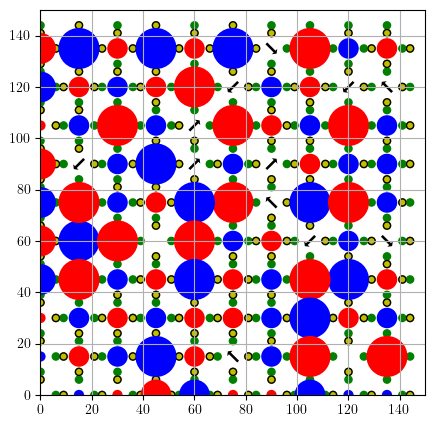

In [21]:
fig, ax = plt.subplots(figsize = (5,5))
col.display(ax)
v.display(ax)

In [ ]:
phi = []
runs = 10

for angle in tqdm([88,89,90]):
    clear_output(wait=True)

    angle_chirs = [get_chirality_on_realization(params,angle,i,last_frame=None) for i in range(1,runs+1)]

    phi.append(angle_chirs)

phi

In [31]:
phi_df = pd.DataFrame(phi)
phi_df.to_csv("../data/test12/chirality.csv")
phi_df

,0,1,2,3,4,5,6,7,8,9
0,-4,12,-17,-30,-10,-6,29,25,-31,-63
1,1,7,30,-18,-25,8,25,-35,-11,7
2,-14,-6,23,23,-3,-27,6,-26,-33,32
3,23,21,-11,31,-37,-34,4,-22,-4,-32
4,15,-12,33,59,37,19,8,1,21,-7
...,...,...,...,...,...,...,...,...,...,...
86,-4,-2,1,0,1,1,2,0,0,1
87,-2,-2,0,0,-1,0,0,1,1,0
88,-1,2,2,1,-1,-1,-2,0,-1,0
89,-1,4,5,1,0,-1,0,1,2,2


In [32]:
phi_df.applymap(np.abs).mean(axis=1)

0     22.7
1     16.7
2     19.3
3     21.9
4     21.2
      ... 
86     1.2
87     0.7
88     1.1
89     1.7
90     1.8
Length: 91, dtype: float64

# Complementary order parameter

$$
    Q = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

In [ ]:
for angle in tqdm(range(5,90+1)):
    for realization in range(1,10+1):
        angle_path = f"../data/test12/angles/{angle}/ctrj/ctrj{realization}.csv"

        try:
            os.mkdir(f"../data/test12/vertices/{angle}")
        except:
            pass

        vertex_path = f"../data/test12/vertices/{angle}/vertices{realization}.csv"
        ctrj = pd.read_csv(angle_path,index_col=[0,1])
        last_frame = ctrj.index.get_level_values("frame").unique().max()
        try:
            vertices = get_vertices_at_frame(ctrj,last_frame)
        except:
            vertices = get_vertices_at_frame(ctrj,last_frame-1)


        vertices.to_csv(vertex_path)

    clear_output(wait=True)

In [54]:
psi= []
for angle in tqdm(range(90+1)):
    results = [get_charge_order_on_realization(params,'test12',angle,realization) for realization in range(1,10+1) ]
    psi.append(results)

In [111]:
psi_df = pd.DataFrame(psi)
psi_df.to_csv("../data/test12/charges.csv")
psi_df

#  Importing data and ploting

In [130]:
angles_completed = np.sort([int(a) for a in os.listdir("../data/test11/angles")])
phi_df = pd.read_csv("../data/test11/chirality.csv",index_col=0).applymap(np.abs)
psi_df = pd.read_csv("../data/test11/charges.csv",index_col=0).applymap(np.abs)

In [133]:
phi_means = phi_df.mean(axis=1).to_list()
phi_sigmas = phi_df.var(axis=1).to_list()

psi_means = psi_df.mean(axis=1).to_list()
psi_sigmas = psi_df.var(axis=1).to_list()


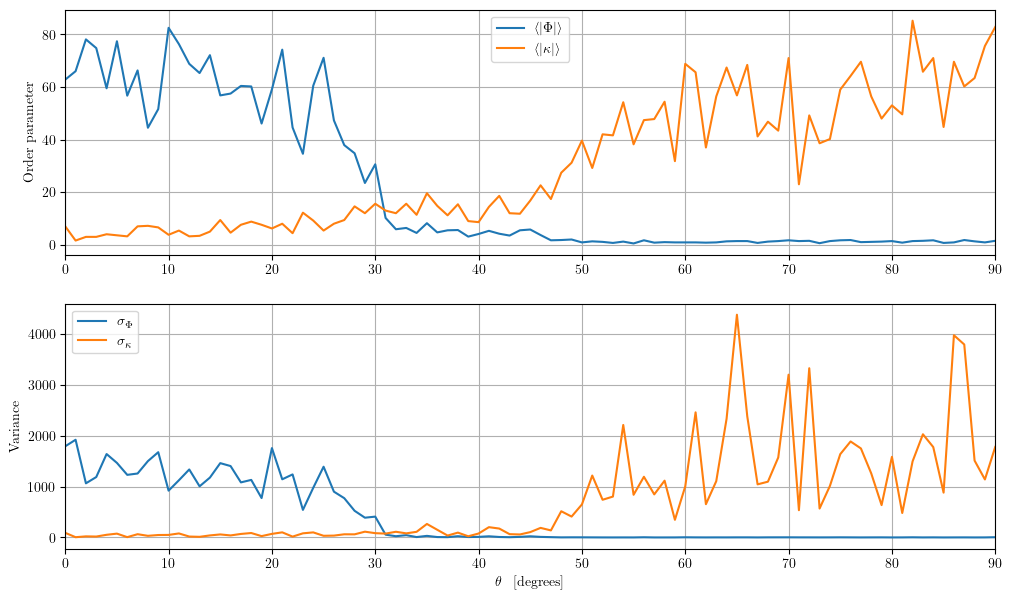

In [152]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

ax = axes[0]
ax.plot(angles_completed,phi_means, label = "$\\langle |\\Phi|\\rangle$")
ax.plot(angles_completed,psi_means, label = "$\\langle |\\kappa|\\rangle$")
ax.set_ylabel("Order parameter")
ax.set_xlim(0,90)
ax.legend()

ax = axes[1]

ax.plot(angles_completed,phi_sigmas, label="$\\sigma_\\Phi$")
ax.plot(angles_completed,psi_sigmas, label="$\\sigma_\\kappa$")

ax.set_xlabel("$\\theta$ \, [degrees]")
ax.set_ylabel("Variance")

ax.legend()

ax.set_xlim(0,90)

plt.show()

fig.savefig("../data/test11/order_parameters.png",dpi=300)